### TC composite averaging
__Objective:__ get composite TC profile to see if there are any systematic differences between a typical model control-run TC and a KillTC-run surviving TC

#### Imports

In [140]:
import cftime
import datetime
import numpy as np
import os
import pandas as pd
import pickle
import random
import scipy
import time
import xarray as xr

import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

#### Data retrieval

##### Save notebook session

In [2]:
import dill
# dill.dump_session('../backup/202303290810.db')
dill.load_session('../backup/202303282020.db')  

##### Pickle load

In [3]:
import pickle
with open('../backup/KillTC-storm_tracks.pkl', 'rb') as handle:
    storage = pickle.load(handle)

##### Relevant directories to model data

In [4]:
dirs = {'AM2.5_tc_ctrl': '/tigress/wenchang/analysis/TC/AM2.5/CTL1990s_tigercpu_intelmpi_18_540PE/model_out/POSTP',
        'AM2.5_tc_ktc2': '/tigress/wenchang/analysis/TC/AM2.5ktc2/CTL1990s_killtc13-13-15_tigercpu_intelmpi_18_540PE/modelout/POSTP',
        'HIRAM_tc_ctrl': '/tigress/wenchang/analysis/TC/HIRAM/CTL1990s_v201910_tigercpu_intelmpi_18_540PE/model_out/POSTP',
        'HIRAM_tc_ktc2': '/tigress/wenchang/analysis/TC/HIRAMktc2/CTL1990s_v201910_killtc13-13-15_tigercpu_intelmpi_18_540PE/modelout/POSTP'}
        
        # 'AM2.5_tc_ctrl': '/tigress/wenchang/MODEL_OUT/AM2.5/CTL1990s_tigercpu_intelmpi_18_540PE/analysis_lmh/cyclones_gav_ro110_1C_330k',
        # 'AM2.5_tc_ktc2': '/tigress/wenchang/MODEL_OUT/AM2.5ktc/CTL1990s_killtc12_tigercpu_intelmpi_18_540PE/analysis_lmh/cyclones_gav_ro110_1C_330k', 
        # 'HIRAM_tc_ctrl': '/tigress/wenchang/MODEL_OUT/HIRAM/CTL1990s_v201910_tigercpu_intelmpi_18_540PE/analysis_lmh/cyclones_gav_ro110_2p5C_330k',
        # 'HIRAM_tc_ktc2': '/tigress/wenchang/MODEL_OUT/HIRAMktc2/CTL1990s_v201910_killtc13-13-15_tigercpu_intelmpi_18_540PE/analysis_lmh/cyclones_gav_ro110_1C_330k'}

##### Get storm-specific data

In [219]:
# Define model run and TC type ('TS' for all storms or 'C15w' for hurricanes)
experiment_type = 'AM2.5_tc_ktc2'
tc_class = 'C15w'

# Get TCs that survived the KillTC algorithm
storms_data = storage[tc_class][experiment_type].copy()

# Define function to parse through Dataframe time string and extract relevant quantities to cftime object
to_cftime = lambda x: cftime.datetime(year=int(x[0:4]), month=int(x[4:6]), day=int(x[6:8]), hour=int(x[8:10]), 
                                      has_year_zero=False)
# Convert time strings to cftime objects to match time objects in AM2.5 output files
storms_data['time'] = storms_data['time'].apply(to_cftime)

# Get times at which storms reach maximum strength for data accessing
times = []
# For each unique storm, get the time at which storm is at peak strength
for storm_id in storms_data['storm_id'].unique():
    # Pull storm-specific data
    temp = storms_data.loc[storms_data['storm_id'] == storm_id]
    # Get timestamp at which peak wind occurs
    temp_max_wnd = temp.loc[temp['max_wnd'] == temp['max_wnd'].max()]
    # If multiple timestamps share the same maximum wind speed, get the strongest by minimum SLP
    if len(temp_max_wnd) > 1:
        temp_max_wnd = temp_max_wnd.loc[temp_max_wnd['slp'] == temp_max_wnd['slp'].min()]
    # Extract time
    temp_time = temp_max_wnd.time.values[0]
    # Create datetime object
    temp_time = datetime.datetime(year=temp_time.year, month=temp_time.month, day=temp_time.day, hour=temp_time.hour)
    # Append timestamp to list for future concatenation
    times.append(temp_time)

# Container list for Datasets
ds = []
output_type = 'atmos_4xdaily'
# Iterate by year, since files are produced by year
for year, v in pd.DataFrame(times, columns=['date']).set_index('date').groupby(pd.Grouper(freq='1Y')):
    # If there are any recorded storms in thay year, pull them
    if len(v.index) > 0:
        # Generate cftime objects to allow for indexing from the model output
        sel_dates = [cftime.DatetimeNoLeap(year=date.year-1900, month=date.month, day=date.day, hour=date.hour) for date in v.index]
        # Get N random storm per year if more than 1 in a given year
        threshold = 1
        if len(v.index) > threshold:
            sel_dates = random.sample(sel_dates, threshold)
        # Get data for the iterand year
        temp_ds = pull(experiment_type, output_type, year=year.year, mode='other')
        # If not None, grab the corresponding storm dates from that year
        if temp_ds:
            try:
                temp_ds = temp_ds.sel(time=sel_dates)
            except:
                continue
    # Append to container list
    ds.append(temp_ds)
    # Override to prevent long runtimes
    if year.year > 2002:
        break
# Remove None values from the list
ds = [x for x in ds if x is not None]
# Concatenate over the time dimension
ds = xr.concat(ds, dim='time')

In [12]:
ds_ctrl = ds.copy()
storms_data_ctrl = storms_data.copy()

In [6]:
ds_hiram_ctrl = ds.copy()
storms_data_hiram_ctrl = storms_data.copy()

In [14]:
ds_ktc = ds.copy()
storms_data_ktc = storms_data.copy()

In [9]:
ds_hiram_ktc = ds.copy()
storms_data_hiram_ktc = storms_data.copy() 

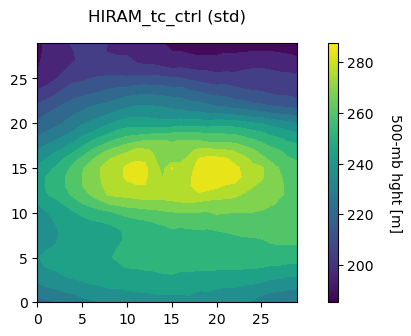

In [133]:
# Get storm data at corresponding times
param = 'h500'
output_attr = 'std'
analysis_model = 'HIRAM_tc_ctrl'
comparison = False
comparison_datasets = ['HIRAM_tc_ctrl', 'HIRAM_tc_ktc2']

ds_list = {'HIRAM_tc_ctrl': {'ds': ds_hiram_ctrl, 'pd': storms_data_hiram_ctrl},
           'HIRAM_tc_ktc2': {'ds': ds_hiram_ktc, 'pd': storms_data_hiram_ktc}}
analysis_ds = {k: [] for k in ds_list.keys()}

pd_out = []

for iter_name, iter_values in ds_list.items():
    storms = []
    iter_ds, storms_data = iter_values['ds'], iter_values['pd']
    for time in iter_ds.time.values:
        time = cftime.datetime(year=time.year+1900, month=time.month, 
                                     day=time.day, hour=time.hour)
        storms.append(storms_data.loc[storms_data['time'] == time])
    # Iterate through storm data to filter xArray data for each one
    storm_composite = []
    # Define spatial bounding box around each TC (in degrees)
    box = 15
    for i, storm in enumerate(storms):
        # Only select the first storm of each year
        storm = storm.iloc[0]
        
        storm_time = cftime.DatetimeNoLeap(year=storm.time.year-1900, 
                                           month=storm.time.month, 
                                           day=storm.time.day, 
                                           hour=storm.time.hour, 
                                           has_year_zero=True)

        iter_ds['U'] = np.sqrt(iter_ds['u_ref']**2 + iter_ds['v_ref']**2)
        
        temp_ds = iter_ds.sel(grid_xt=np.arange(storm.lon-box, storm.lon+box), 
                         grid_yt=np.arange(storm.lat-box, storm.lat+box), 
                         method='nearest')

        try:
            temp_np = temp_ds.sel(time=storm_time).isel(time=0)[param].values
            radius = radius_estimate(temp_ds.sel(time=storm_time).isel(time=0), storm, box)
        except:
            temp_np = temp_ds.sel(time=storm_time)[param].values
            radius = radius_estimate(temp_ds.sel(time=storm_time), storm, box)

        if i > 0:
            if temp_np.shape == storm_composite[0].shape:
                storm_composite.append(temp_np)
        else:
            storm_composite.append(temp_np)
            
        storm['radius'] = radius
        pd_out.append(storm)

    if output_attr == 'mean':
        storm_output = np.nanmean(np.dstack(storm_composite), axis=2)
    if output_attr == 'std':
        storm_output = np.nanstd(np.dstack(storm_composite), axis=2)
        
    analysis_ds[iter_name] = storm_output
    
pd_out = pd.concat(pd_out, axis=1).reset_index().T
header = pd_out.iloc[0]
pd_out = pd_out[1:]
pd_out.columns = header
                      
if comparison:
    ds_out = analysis_ds[comparison_datasets[1]] - analysis_ds[comparison_datasets[0]]
else:
    ds_out = analysis_ds[analysis_model]

''' Plotting. '''

fig = plt.figure(figsize=(4, 3.25), constrained_layout=True)
gs = fig.add_gridspec(ncols=2, width_ratios=[0.97, 0.03], wspace=0)
ax_im = fig.add_subplot(gs[0, 0])

levels = 16

vmin, vmax = np.nanmin(ds_out), np.nanmax(ds_out)

if comparison:
    if vmin < 0 and vmax > 0:
        norm = matplotlib.colors.CenteredNorm(vcenter=0)
        cmap = 'RdBu_r'
    elif vmin < 0 and vmax < 0:
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = 'Blues_r'
    else:
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = 'Reds'
else:
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = 'viridis'

im = ax_im.contourf(ds_out, levels=levels, norm=norm, cmap=cmap)
# im = ax_im.pcolormesh(ds_out, norm=norm, cmap=cmap)
ax_im.set_aspect('equal')

if comparison:
    title_str = '{0} - {1} ({0})'.format(comparison_datasets[1], comparison_datasets[0])
else:
    title_str = '{0} ({1})'.format(analysis_model, output_attr)
ax_im.set_title(title_str, y=1.05)

ax_cb = fig.add_subplot(gs[0, 1])
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax_cb)
cb_label = '{0} [{1}]'.format(temp_ds.sel(time=storm_time)[param].attrs['long_name'], 
                              temp_ds.sel(time=storm_time)[param].attrs['units'])
cb.set_label(cb_label, rotation=270, labelpad=20)

#### Methods

In [131]:
def radius_estimate(ds, storm, box, overlay_check=False):
    
    '''
    Algorithm to estimate the radius of a TC based on filters set below.
    Returns a radius in meters.
    
    Note to self: this works well with filters based on standard deviations from the mean. Before you start fucking around, save the current methodology.
    '''
    
    if 'U' not in ds.data_vars.keys():
        ds['U'] = np.sqrt(ds['u_ref']**2 + ds['v_ref']**2)
    
    # Define number of standard deviations to analyze
    sigma = 1
    # Relative thresholds (mean + standard deviation)
    filters = {'vort850': [ds['vort850'] > (ds['vort850'].mean() + sigma*ds['vort850'].std()),
                           ds['vort850'] < (ds['vort850'].mean() - sigma*ds['vort850'].std())],
               'tm': ds['tm'] > (ds['tm'].mean() + sigma*ds['tm'].std()),
               'slp': ds['slp'] < (ds['slp'].mean() - sigma*ds['slp'].std()),
               'U': ds['U'] > (ds['U'].mean() + 2*sigma*ds['U'].std())}
    
    # Exact magnitude thresholds
    # filters = {'vort850': [ds['vort850'] > (ds['vort850'].mean() + sigma*ds['vort850'].std()),
    #                        ds['vort850'] < (ds['vort850'].mean() - sigma*ds['vort850'].std())],
    #            'tm': ds['tm'] > (ds['tm'].mean() + sigma*ds['tm'].std()),
    #            'slp': ds['slp'] < 1000,
    #            'U': ds['U'] > 15}
        
    conditional = (filters['vort850'][0] | filters['vort850'][1]) & filters['slp'] & filters['U'] & filters['tm']
    
    try:
        radius_ds = ds.where(conditional).sel(grid_xt=np.arange(storm.lon-box, storm.lon+box), 
                                              grid_yt=np.arange(storm.lat-box, storm.lat+box),
                                              method='nearest')
        
        ds_np = radius_ds['u_ref'].values
        crop_x, crop_x_idx = ds_np[~np.all(np.isnan(ds_np), axis=1), :], ~np.all(np.isnan(ds_np), axis=1)
        crop_y, crop_y_idx = crop_x[:, ~np.all(np.isnan(crop_x), axis=0)], ~np.all(np.isnan(crop_x), axis=0)
        arr = np.ma.masked_values(ds_np, np.nan)
        
        if crop_y.shape != (0, 0):

            lons = np.min(radius_ds.grid_xt.values[crop_x_idx]), np.max(radius_ds.grid_xt.values[crop_x_idx])
            lats = np.min(radius_ds.grid_yt.values[crop_y_idx]), np.max(radius_ds.grid_yt.values[crop_y_idx])
            coords = [lons[0], lats[0]], [lons[1], lats[1]]
            # Derive radius from coordinate pairs (divide by 2, as diameter is obtained)
            radius = coords_to_dist(coords[0], coords[1])/2e3
            
            # Overlay the storm size algorithm output on maps of the storms 
            if overlay_check:
                fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
                ax.coastlines()

                ds['U'].plot(ax=ax)
                ax.pcolormesh(radius_ds.grid_xt, radius_ds.grid_yt, arr, 
                              zorder=9, cmap='Reds', transform=ccrs.PlateCarree())

                ax.set_extent([storm.lon-box, storm.lon+box, storm.lat-box, storm.lat+box])
                ax.set_title('radius: {0:.2f} km'.format(radius))
                
            return radius

    except:
        return np.nan

In [94]:
def coords_to_dist(a, b):
    ''' Convert coordinates to distance in meters. '''
    
    R = 6371e3
    
    lon_a, lat_a = np.array(a)*np.pi/180
    lon_b, lat_b = np.array(b)*np.pi/180
    
    dlon, dlat = lon_b - lon_a, lat_b - lat_a
    
    a = np.sin(dlat/2)**2 + np.cos(lat_a)*np.cos(lat_b)*np.sin(dlon/2)**2    
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    distance = R*c
    
    return distance

In [25]:
def pull(experiment, output_type, year=None, mode='tc'):
    ''' Method to read data for given parameters. '''
    
    # Retrieve directory name for corresponding model and experiment
    dirname = dirs[experiment]
    # Get filenames for corresponding files (0 index used for test runs)
    if mode == 'tc':
        fname = sorted([os.path.join(dirname, file) for file in os.listdir(dirname) 
                        if (output_type == file.split('.')[0]) and ('.nc' in file) 
                        and ('yearly' not in file) and ('all' not in file)])
        print(fname)
    else:
        if year:
            filename = '{0:04d}0101.{1}.nc'.format(year-1900, output_type)
            try:
                fname = os.path.join(dirname, filename)
                # Retrieve data
                data = xr.open_dataset(fname)
            except:
                return None
        else:
            fname = sorted([os.path.join(dirname, file) for file in os.listdir(dirname) 
                            if (output_type == file.split('.')[1]) and ('.nc' in file)])[48:50]
            # Retrieve data
            data = xr.open_mfdataset(fname)
    
    return data